In [1]:
import json
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plot_map
import matplotlib as mpl
import seaborn as sns
import sys
import os
import basics
import geopandas as gpd
import pymysql
from shapely.geometry import Point 
from shapely.geometry import Polygon
from shapely.geometry import LineString
import pyproj
from urllib.parse import quote
import string
import math
from coord_convert.transform import wgs2gcj, wgs2bd, gcj2wgs, gcj2bd, bd2wgs, bd2gcj 
import importlib
importlib.reload(basics)

<module 'basics' from 'F:\\study1\\研一\\疫情影响轨迹分析相关研究\\疫情对微观出行行为的影响\\03不同出行群体面对疫情的行为反应\\义乌POI提取\\basics.py'>

# 1.get various type of POI

In [12]:
# 关键字搜索，每次最多返回1000个POI信息，适合数量较少的POI类型
def getPOIKeywords(poitype,citycode):
    POIList = []
    for page in range(1 , 46):
        url = "https://restapi.amap.com/v3/place/text?key="+ak+"&keywords=&types="+poitype+"&city="+citycode+\
        "&children=l&offset=20&page="+str(page)+"&extensions=all"
        json_obj = urllib.request.urlopen(url)
        json_data = json.load(json_obj)
        try:
            pois = json_data['pois']
        except Exception as e:
            print("错误",url)
            print(e)
            continue
        if (pois != []):
            for j in range(0,len(pois)):
                poi_j = pois[j]
                id = poi_j['id']
                lon = float(poi_j['location'].split(',')[0])
                lat = float(str(poi_j['location']).split(',')[1])
                name = poi_j['name']
                poi = basics.PointWithAttr(id,lon,lat,poitype,name)
                POIList.append(poi)
    return POIList

In [13]:
#范围搜索，将行政区划分为num个子区域，用以无遗漏采集POI
def getPOIPolygon(poitype,citycode,num):
    POIList = []
    # 获取citycode对应的行政边界
    districtBoundryUrl = "http://restapi.amap.com/v3/config/district?key="+ak+"&keywords="+citycode+"&subdistrict=0&extensions=all"
    json_obj=urllib.request.urlopen(districtBoundryUrl)
    json_data=json.load(json_obj)
    districts = json_data['districts']
    polyline = districts[0]['polyline']
    center = districts[0]['center']
    pointscoords = polyline.split(';')
    newlinelength=int(len(pointscoords) / num)  # 每个子区域的点数目
    # 将行政区域划分为num个子区域，获得每个子区域的poi
    boundryMarks = [] # 标记行政区域的划分点
    for i in range(0,len(pointscoords) , newlinelength):
        boundryMarks.append(i)
    boundryMarks.append(len(pointscoords) - 1)
    for i in range(0 , len(boundryMarks) - 1):
        firstMark = boundryMarks[i]
        lastMark = boundryMarks[i+1]
        newboundry = [center] #新的多边形划分子区，从中心开始
        for j in range(firstMark , lastMark+1):
            newboundry.append(pointscoords[j])
        newboundry.append(center)  #最后回到center，达到闭合
        # newboundryStr是多边形的边界
        newboundryStr = "|".join(newboundry)
        for page in range(1,46):
            url="http://restapi.amap.com/v3/place/polygon?key="+ak+"&polygon="+newboundryStr+"&keywords=&types="+poitype+ \
            "&offset=20&page="+str(page)+"&extensions=all"
            json_obj=urllib.request.urlopen(url)
            json_data=json.load(json_obj)
            try:
                pois=json_data['pois']
            except Exception as e:
                print("错误" , url)
                print(e)
                continue
            if (pois != []):
                for j in range(0,len(pois)):
                    poi_j=pois[j]
                    id=poi_j['id']
                    lon=float(poi_j['location'].split(',')[0])
                    lat=float(str(poi_j['location']).split(',')[1])
                    name=poi_j['name']
                    poi=basics.PointWithAttr(id,lon,lat,poitype,name)
                    POIList.append(poi)
    return POIList

In [14]:
# 将poi写入txt文件ok
def writePOIs2File(POIList,outputfile):
    f = open(outputfile,'a' ,encoding="utf-8")
    for i in range(0 , len(POIList)):
        f.write(POIList[i].id+";"+POIList[i].name+";"+POIList[i].type+';'+str(POIList[i].lon)+';'+str(POIList[i].lat)+"\n")
    f.close()    

In [20]:
# 密钥ak
ak='your ak'
# 将采集的POI数据保存在output_directory文件夹里
output_directory="output directory"
if not os.path.exists(output_directory+"poi\\"):
    os.mkdir(output_directory+"poi\\")
try:
    typefile=open(output_directory+"poitype.txt",'r')
except Exception as e:
    print('错误提示:请将poitype.txt复制到'+output_directory+"下")
poitypeList=typefile.readlines()
for poitype in poitypeList:  # 遍历各种类型，并下载每种类型的poi
    poitype=poitype.split('\n')[0]  # 去掉换行符
    #行政区域编码citycode
#     citycodes={'玄武区':'320102','秦淮区':'320104','建邺区':'320105','古楼区':'320106','浦口区':'320111','栖霞区':320113,\
#                '雨花台区':'320114','江宁区':'320115'}
    citycodes={'义乌市':'330782'}
    for citycode in citycodes.values():  # 遍历行政区域编码，将各个行政区域的poi都下载下来
        #调用关键字搜索的getPOIKeywords函数，获取POI数量较少的案例
        POIList = getPOIKeywords(poitype , citycode)
        # 关键字搜索返回POI数量大于900个，则调用多边形搜索
        # getPOIPolygon函数，获取POI数量较多的类别
        if (len(POIList)>=900):
            POIList = []
            POIList=getPOIPolygon(poitype,citycode,12)
            outputfile1=output_directory+"poi\\"+poitype+"_"+citycode+"_polygon.txt"
            f=open(outputfile1,'w',encoding="utf-8")
            f.close()
            print(citycode , poitype,len(POIList))
            writePOIs2File(POIList,outputfile1)
        else:
            outputfile = output_directory+"poi\\"+poitype+"_"+citycode+"_keywords.txt"
            f=open(outputfile,'w',encoding="utf-8")
            f.close()
            print(citycode,poitype,len(POIList))
            writePOIs2File(POIList,outputfile)
# 合并poitype类型的文本文件
basics.mergetxt(output_directory+"poi\\",output_directory+"final.txt")

330782 050000 9458
330782 060000 10917
330782 070000 9779
330782 080000 1504
330782 090000 2748
330782 110000 477
330782 120000 2222
330782 130000 4095
330782 140000 3703
330782 150000 4883
330782 170000 9417


# 2.convert the poi to GPS 84

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df_poi = pd.read_csv("义乌POI.txt",header=None,names=['ID','name','type','lng','lat'],dtype={'type':object},sep=';',encoding = 'utf-8')
df_poi.head(2)

ID            name    type         lng        lat
0  B0FFFGLQ6U     鞑子烤羊腿(贝村总店)  050000  120.057625  29.294353
1  B024314FWS  阿锋烧烤城(贝村烧烤一条街)  050000  120.058108  29.294483

In [6]:
df_poi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59203 entries, 0 to 59202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      59203 non-null  object 
 1   name    59203 non-null  object 
 2   type    59203 non-null  object 
 3   lng     59203 non-null  float64
 4   lat     59203 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.3+ MB


# 3.get YIWU district boundry

In [7]:
# 功能：采集行政区域边界
# 返回保存边界信息的BoundryWithAttr对象
def getDistrictBoundry(ak,citycode):
    districtBoundryUrl = "http://restapi.amap.com/v3/config/district?key="+ak+"&keywords="+citycode+"&subdistrict=0&extensions=all"
    print(districtBoundryUrl)
    districtBoundryUrl = quote(districtBoundryUrl, safe=string.printable)
    json_obj = urllib.request.urlopen(districtBoundryUrl)
#     json_obj = response.read().decode('utf-8','ignore').replace(u'\xa9', u'')
    json_data=json.load(json_obj)
    districts=json_data['districts']
    try:
        polyline = districts[0]['polyline']
        centerLon=districts[0]['center'].split(',')[0]
        centerLat=districts[0]['center'].split(',')[1]
    except Exception as e:
        print("error!")
    pointscoords=polyline.split(';')
    point=basics.PointWithAttr(0,centerLon,centerLat,"行政区域",citycode)
    districtBoundry=basics.BoundryWithAttr(point,pointscoords)
    return districtBoundry

In [1]:
ak =  'your ak'
# citycodes={'上城区':'330102','下城区':'330103','江干区':'330104',"拱墅区":'330105',"西湖区":'330106','滨江区':'330108',
#            '萧山区':'330109','余杭区':'330110','富阳区':'330111','临安区':'330112','桐庐县':'330122','淳安县':'330127',
#           '建德市':'330182'}
citycodes={'义乌市':'330782'}
polygon_list = []
centerX_list = []
centerY_list = []
for citycode in citycodes.keys():
    districtBoundry = getDistrictBoundry(ak,citycode)
    tmp = districtBoundry.boundrycoords
    for i in range(len(tmp)):
        tmp[i] = [float(tmp[i].split(',')[0]) , float(tmp[i].split(',')[1])]
    tmp = Polygon(tmp)
    polygon_list.append(tmp)
    centerX_list.append(districtBoundry.point.lon)
    centerY_list.append(districtBoundry.point.lat)

NameError: name 'getDistrictBoundry' is not defined

In [13]:
# 将爬取得到的杭州市行政区保存为shp文件
gdf = {'geometry':polygon_list , 'centerLon':centerX_list , 'centerLat':centerY_list , 
       'name':citycodes.keys(),'adacode':citycodes.values()}
gdf = gpd.GeoDataFrame(gdf , crs = None)
gdf

geometry   centerLon  centerLat  \
0  POLYGON ((119.89714 29.05013, 119.89981 29.051...  120.074911  29.306863   

  name adacode  
0  义乌市  330782

<AxesSubplot:>

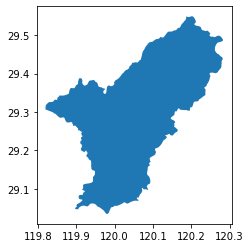

In [14]:
gdf.plot()

In [16]:
gdf.to_file('.\\义乌市行政规划\\义乌市行政区划.shp', encoding="utf-8")

# 4.buffer area analysis

## 4.1classify of detector based on land use type

In [2]:
# 连接mysql数据库
try:
    conn = pymysql.connect(host='host', user='user name', password='password', db='darabase', charset='utf8')
    print('数据库连接成功.')
except:
    print('数据库连接失败.')

数据库连接失败.


In [3]:
# 读取服务器中的电警表
# 读取cameras表
conn.ping(reconnect=True)
cur = conn.cursor()
sql = '''
      select LNG , LAT from cameras
      '''
cur.execute(sql)
conn.commit()
cam = cur.fetchall()
cam = pd.DataFrame(cam)
cam.rename(columns = {0:'lng',1:'lat'} ,inplace = True)
cur.close()
# cam = cam.drop_duplicates()
cam.head(2)

lng      lat
0  120.020  29.1936
1  120.117  29.3676

In [4]:
# 读取义乌poi
df_poi = pd.read_csv("义乌POI.txt",header=None,names=['ID','name','type','lng','lat'],dtype={'type':object},sep=';',encoding = 'utf-8')
df_poi.head(2)

ID            name    type         lng        lat
0  B0FFFGLQ6U     鞑子烤羊腿(贝村总店)  050000  120.057625  29.294353
1  B024314FWS  阿锋烧烤城(贝村烧烤一条街)  050000  120.058108  29.294483

In [5]:
# 将交通设施类型的POI排除，后续单独分析
df_poi_nt = df_poi[df_poi['type'] != '150000']
df_poi_nt.head(2)

ID            name    type         lng        lat
0  B0FFFGLQ6U     鞑子烤羊腿(贝村总店)  050000  120.057625  29.294353
1  B024314FWS  阿锋烧烤城(贝村烧烤一条街)  050000  120.058108  29.294483

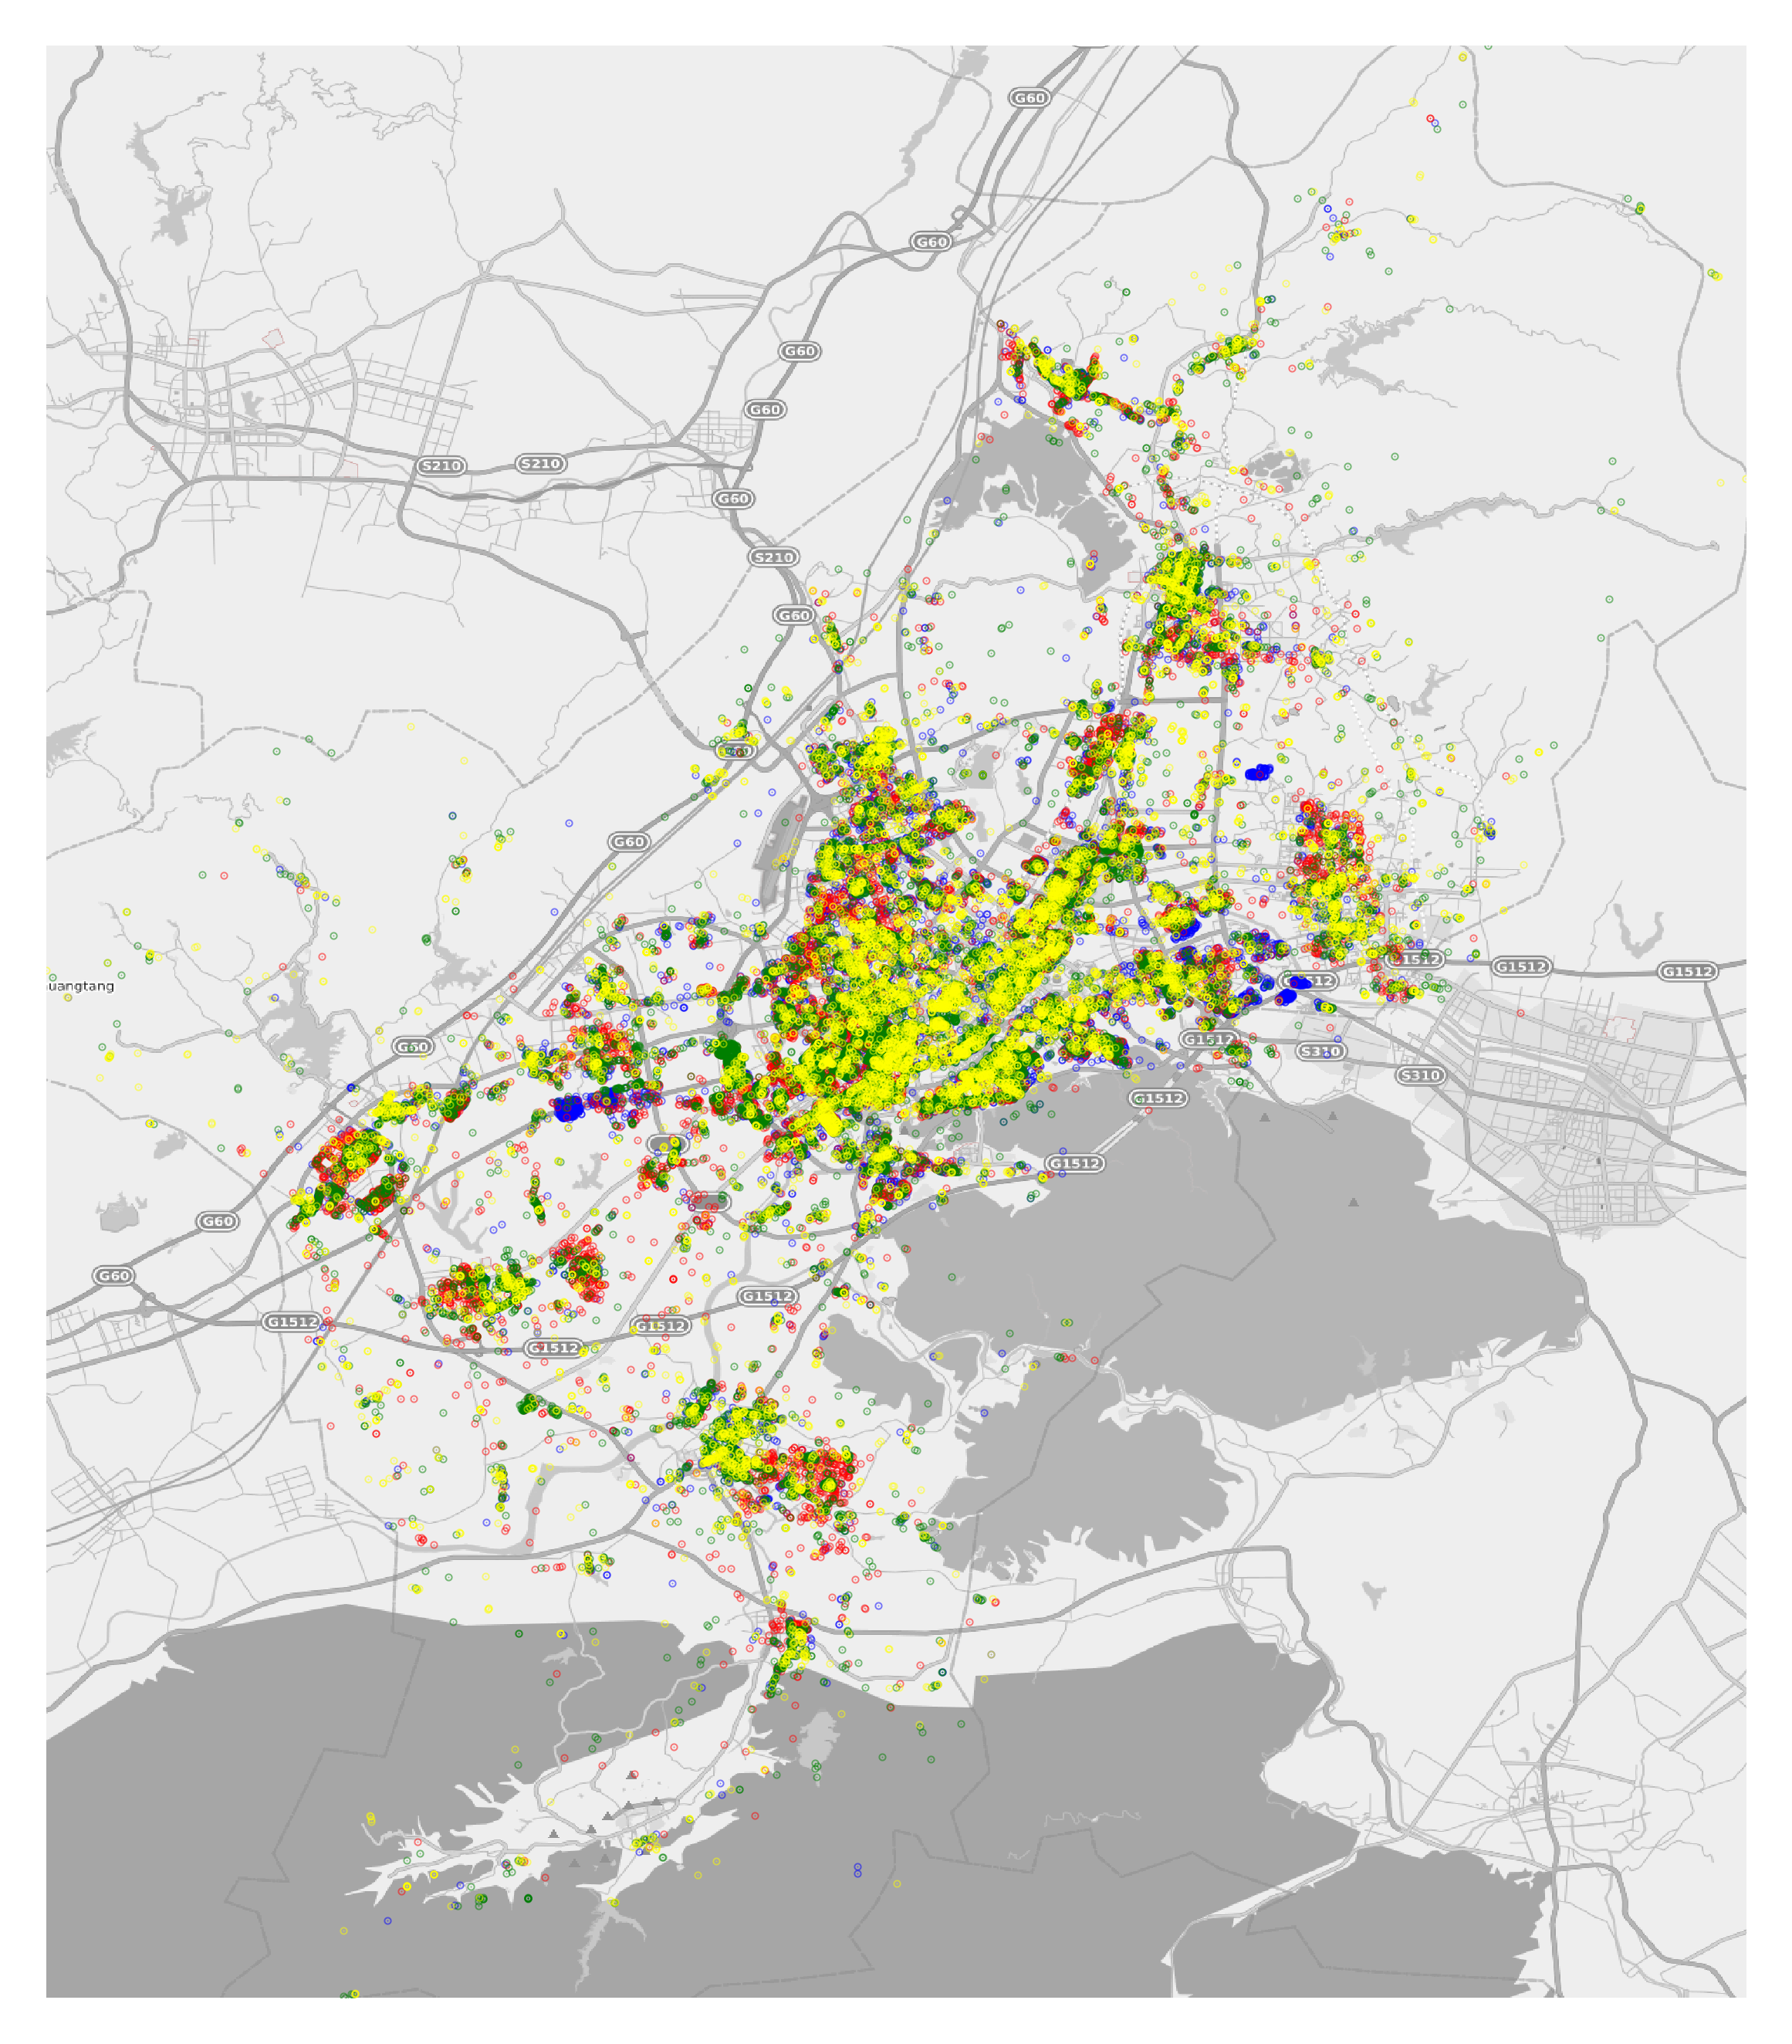

In [6]:
# 将重分类后的POI可视化
bounds = [min(df_poi_nt['lng']),min(df_poi_nt['lat']),max(df_poi_nt['lng']),max(df_poi_nt['lat'])]
fig     = plt.figure(1,(6,6),dpi = 600)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))
#背景
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)
#colorbar
pallete_name = "autumn_r"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
norm = mpl.colors.Normalize(vmin=None, vmax=None)
#plot scatters
plt.scatter(df_poi_nt[(df_poi_nt['type']=='070000')|(df_poi_nt['type']=='120000')]['lng'],
            df_poi_nt[(df_poi_nt['type']=='070000')|(df_poi_nt['type']=='120000')]['lat'],c = "blue" ,s= 0.05,alpha=0.5)
plt.scatter(df_poi_nt[(df_poi_nt['type']=='170000')]['lng'],
            df_poi_nt[(df_poi_nt['type']=='170000')]['lat'],c = "red" ,s= 0.05,alpha=0.5)
plt.scatter(df_poi_nt[(df_poi_nt['type']=='060000')|(df_poi_nt['type']=='080000')|(df_poi_nt['type']=='110000')|(df_poi_nt['type']=='050000')]['lng'],
            df_poi_nt[(df_poi_nt['type']=='060000')|(df_poi_nt['type']=='080000')|(df_poi_nt['type']=='110000')|(df_poi_nt['type']=='050000')]['lat'],c = "green" ,s= 0.05,alpha=0.5)
plt.scatter(df_poi_nt[(df_poi_nt['type']=='090000')|(df_poi_nt['type']=='130000')|(df_poi_nt['type']=='140000')]['lng'],
            df_poi_nt[(df_poi_nt['type']=='090000')|(df_poi_nt['type']=='130000')|(df_poi_nt['type']=='140000')]['lat'],c = "yellow" ,s= 0.05,alpha=0.5)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

In [7]:
print("POI总数：", len(df_poi_nt))
print("生活居住类POI总数",len(df_poi_nt[(df_poi_nt['type']=='070000')|(df_poi_nt['type']=='120000')]))
print("公司商务类POI总数",len(df_poi_nt[(df_poi_nt['type']=='170000')]))
print("消费娱乐类POI总数",len(df_poi_nt[(df_poi_nt['type']=='060000')|(df_poi_nt['type']=='080000')|(df_poi_nt['type']=='110000')|(df_poi_nt['type']=='050000')]))
print("公共服务类POI总数",len(df_poi_nt[(df_poi_nt['type']=='090000')|(df_poi_nt['type']=='130000')|(df_poi_nt['type']=='140000')]))

POI总数： 54320
生活居住类POI总数 12001
公司商务类POI总数 9417
消费娱乐类POI总数 22356
公共服务类POI总数 10546


In [8]:
# 提取出各个电警缓冲区内各个类型POI的数量

# 定义通过经纬度计算直线距离的函数
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1,lat1,lng2,lat2):
    if lng1 == None or lng2 == None or lat1 == None or lat2 == None:
        return 999999
    elif (lng1 < 119 or lng1 > 121) or (lng2 < 119 or lng2 > 121) or (lat1 < 29 or lat1 > 30) or (lat2 < 29 or lat2 > 30):
        return 999999
    lng1 = float(lng1) ; lng2 = float(lng2) ; lat1 = float(lat1) ; lat2 = float(lat2)
    lng1,lat1,lng2,lat2 = map(radians,[lng1,lat1,lng2,lat2])
    dlon = lng2-lng1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance = 2* asin(sqrt(a))*6371*1000
    distance = round(distance/1000,3)
    return distance

def caldis(u,v):
    # 计算输入矩阵中两个向量的距离
    return geodistance(u[0],u[1],v[0],v[1])

def sma1(ser):
    return (len(ser[ser<=1]))

from scipy.spatial.distance import cdist
# 计算各类型poi密度，计算方式为某类型poi/缓冲区内总poi个数   
for item in list(set(df_poi_nt['type'])):
    # 计算每个电警缓冲区范围内各个类型poi的数量
    tmp = df_poi_nt[df_poi_nt['type'] == item]
    X_mat = cdist(cam[['lng','lat']].values , tmp[['lng','lat']].values , metric=caldis)
    cam[item] = np.apply_along_axis(sma1, 1, X_mat)
    print(item,"已经运行完毕.")
cam.head(2)

080000 已经运行完毕.
130000 已经运行完毕.
170000 已经运行完毕.
060000 已经运行完毕.
120000 已经运行完毕.
070000 已经运行完毕.
140000 已经运行完毕.
050000 已经运行完毕.
090000 已经运行完毕.
110000 已经运行完毕.


lng      lat  080000  130000  170000  060000  120000  070000  140000  \
0  120.020  29.1936      38      60      94     275      21     230      86   
1  120.117  29.3676      17      67     163      97      10      95      26   

   050000  090000  110000  
0     246      89       7  
1     117      46       4

In [9]:
import gc
del X_mat
del tmp
gc.collect()

43

In [10]:
# 上面的步骤已经成功计算出各个poi类型在各个电警缓冲区范围内的绝对数量,现对各个POI进行重分类操作
cam['t1'] = cam['070000']+cam['120000']  # 生活服务类别
cam['t2'] = cam['170000'] # 公司商务
cam['t3'] = cam['060000']+cam['080000']+cam['110000']+cam['050000'] # 消费娱乐
cam['t4'] = cam['090000']+cam['130000']+cam['140000'] # 公共服务
cam.head(2)

lng      lat  080000  130000  170000  060000  120000  070000  140000  \
0  120.020  29.1936      38      60      94     275      21     230      86   
1  120.117  29.3676      17      67     163      97      10      95      26   

   050000  090000  110000   t1   t2   t3   t4  
0     246      89       7  251   94  566  235  
1     117      46       4  105  163  235  139

In [11]:
# 计算internal ranking
# 首先计算相对数量
cam['fdt1'] = cam['t1'] / 1254152
cam['fdt2'] = cam['t2'] / 900405
cam['fdt3'] = cam['t3'] / 2420563
cam['fdt4'] = cam['t4'] / 1070689

# 计算相对数量基础上的各个类别的密度
def calden(ser):
    sumv = sum(ser)
    return [ser[0]/sumv,ser[1]/sumv,ser[2]/sumv,ser[3]/sumv]

cam['tmp'] = cam[['fdt1','fdt2','fdt3','fdt4']].apply(calden , axis=1)
cam['dent1'] = cam[['tmp']].applymap(lambda x : x[0])
cam['dent2'] = cam[['tmp']].applymap(lambda x : x[1])
cam['dent3'] = cam[['tmp']].applymap(lambda x : x[2])
cam['dent4'] = cam[['tmp']].applymap(lambda x : x[3])
cam.drop(columns=['tmp'],inplace=True)
cam.head(2)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


lng      lat  080000  130000  170000  060000  120000  070000  140000  \
0  120.020  29.1936      38      60      94     275      21     230      86   
1  120.117  29.3676      17      67     163      97      10      95      26   

   050000  ...   t3   t4      fdt1      fdt2      fdt3      fdt4     dent1  \
0     246  ...  566  235  0.000200  0.000104  0.000234  0.000219  0.264084   
1     117  ...  235  139  0.000084  0.000181  0.000097  0.000130  0.170284   

      dent2     dent3     dent4  
0  0.137755  0.308545  0.289616  
1  0.368201  0.197464  0.264051  

[2 rows x 24 columns]

In [12]:
print(len(cam))
cam.dropna(inplace=True)
len(cam)

8339


8214

尝试了对下述几种特征进行聚类：

1. 在此定义External Ranking(ER)和Internal Ranking(IR)，ER指根据电警缓冲区内某类别POI的数量对所有电警该类别POI进行排序，该排序称为ER，比如电警A是所有电警中餐饮服务类别POI数量最多的，则将其餐饮服务类POI的ER标记为1。IR指根据电警缓冲区内各类别POI的相对数量多少对各类别POI进行排序。将ER和IR作为特征，进行标准化后进行聚类，最佳效果是两个簇。
2. 将各类别绝对数量和基于相对数量的密度作为特征，标准化后进行聚类，发现最佳效果是两个簇。
3. 仅仅使用基于相对数量的密度作为特征，不进行标准化直接聚类，最佳效果是三个簇。

因此选用第三种聚类方式。

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


2 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


3 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


4 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


5 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


6 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


7 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


8 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


9 clustering method has been successfully run


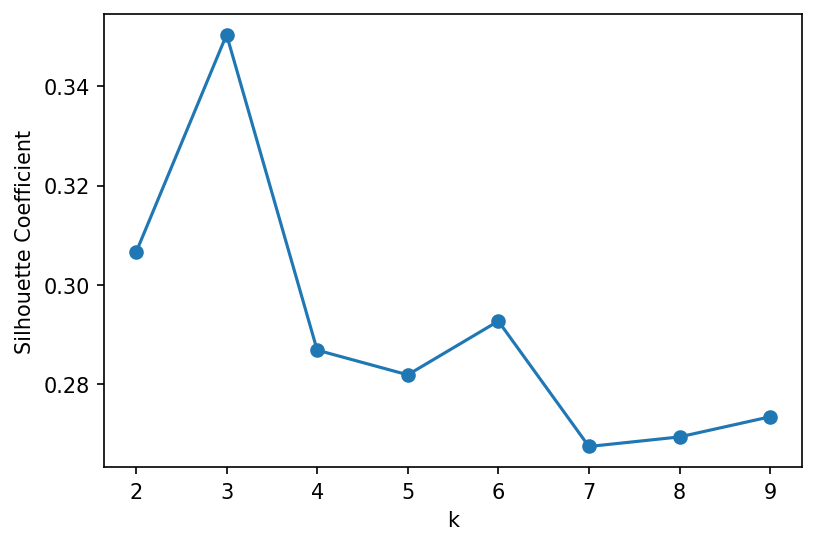

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
# # 数据标准化
# scaler = StandardScaler()
# data = scaler.fit_transform(cam[['dent1','dent2','dent3','dent4']].values)
data = cam[['dent1','dent2','dent3','dent4']].values
plt.rcParams['figure.dpi'] = 150 #分辨率
Scores = [] # 存储不同初始聚类数目的轮廓系数值
for k in range(2,10):  
    estimator = KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器  
    labels = estimator.fit_predict(data)  
    Scores.append(silhouette_score(data , labels , random_state=0))  
    print("{0} clustering method has been successfully run".format(k))
X = range(2,10)  
plt.xlabel('k')  
plt.ylabel('Silhouette Coefficient')  
plt.plot(X,Scores,'o-')  
plt.show()  

In [14]:
estimator = KMeans(n_clusters=3,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器  
labels = estimator.fit_predict(data)  
cam['label'] = labels
cam.head(2)

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


lng      lat  080000  130000  170000  060000  120000  070000  140000  \
0  120.020  29.1936      38      60      94     275      21     230      86   
1  120.117  29.3676      17      67     163      97      10      95      26   

   050000  ...   t4      fdt1      fdt2      fdt3      fdt4     dent1  \
0     246  ...  235  0.000200  0.000104  0.000234  0.000219  0.264084   
1     117  ...  139  0.000084  0.000181  0.000097  0.000130  0.170284   

      dent2     dent3     dent4  label  
0  0.137755  0.308545  0.289616      1  
1  0.368201  0.197464  0.264051      0  

[2 rows x 25 columns]

In [15]:
for i in range(3):
    print(cam[['t1','t2','t3','t4','dent1','dent2','dent3','dent4','label']][cam[['label']]['label']==i].describe())

                t1           t2           t3           t4        dent1  \
count  2340.000000  2340.000000  2340.000000  2340.000000  2340.000000   
mean     95.037179   122.449573   173.106838    67.557692     0.185722   
std     118.056370   119.274110   230.363908    68.492468     0.072999   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%      16.000000    34.000000    30.000000    20.000000     0.142861   
50%      60.500000    95.500000   100.000000    48.000000     0.197252   
75%     127.000000   171.000000   230.000000    88.000000     0.240274   
max     700.000000   679.000000  1492.000000   372.000000     0.433537   

             dent2        dent3        dent4   label  
count  2340.000000  2340.000000  2340.000000  2340.0  
mean      0.431350     0.174002     0.208925     0.0  
std       0.097987     0.059773     0.080854     0.0  
min       0.321853     0.000000     0.000000     0.0  
25%       0.357842     0.136660     0.150598     0.0  
50%

In [16]:
# 为了进行绘图展示，进行坐标系转换，将GCJ02转换为84坐标系
def cotrans(ser):
    return list(gcj2wgs(ser[0],ser[1]))

tmp = cam[['lng','lat']].apply( cotrans , axis=1)
tmp = pd.DataFrame(np.array(list(tmp)))
tmp['label'] = cam['label']
tmp.rename(columns={0:'lng',1:'lat'},inplace=True)
tmp.head(2)

lng        lat  label
0  120.015366  29.196295    1.0
1  120.112282  29.370040    0.0

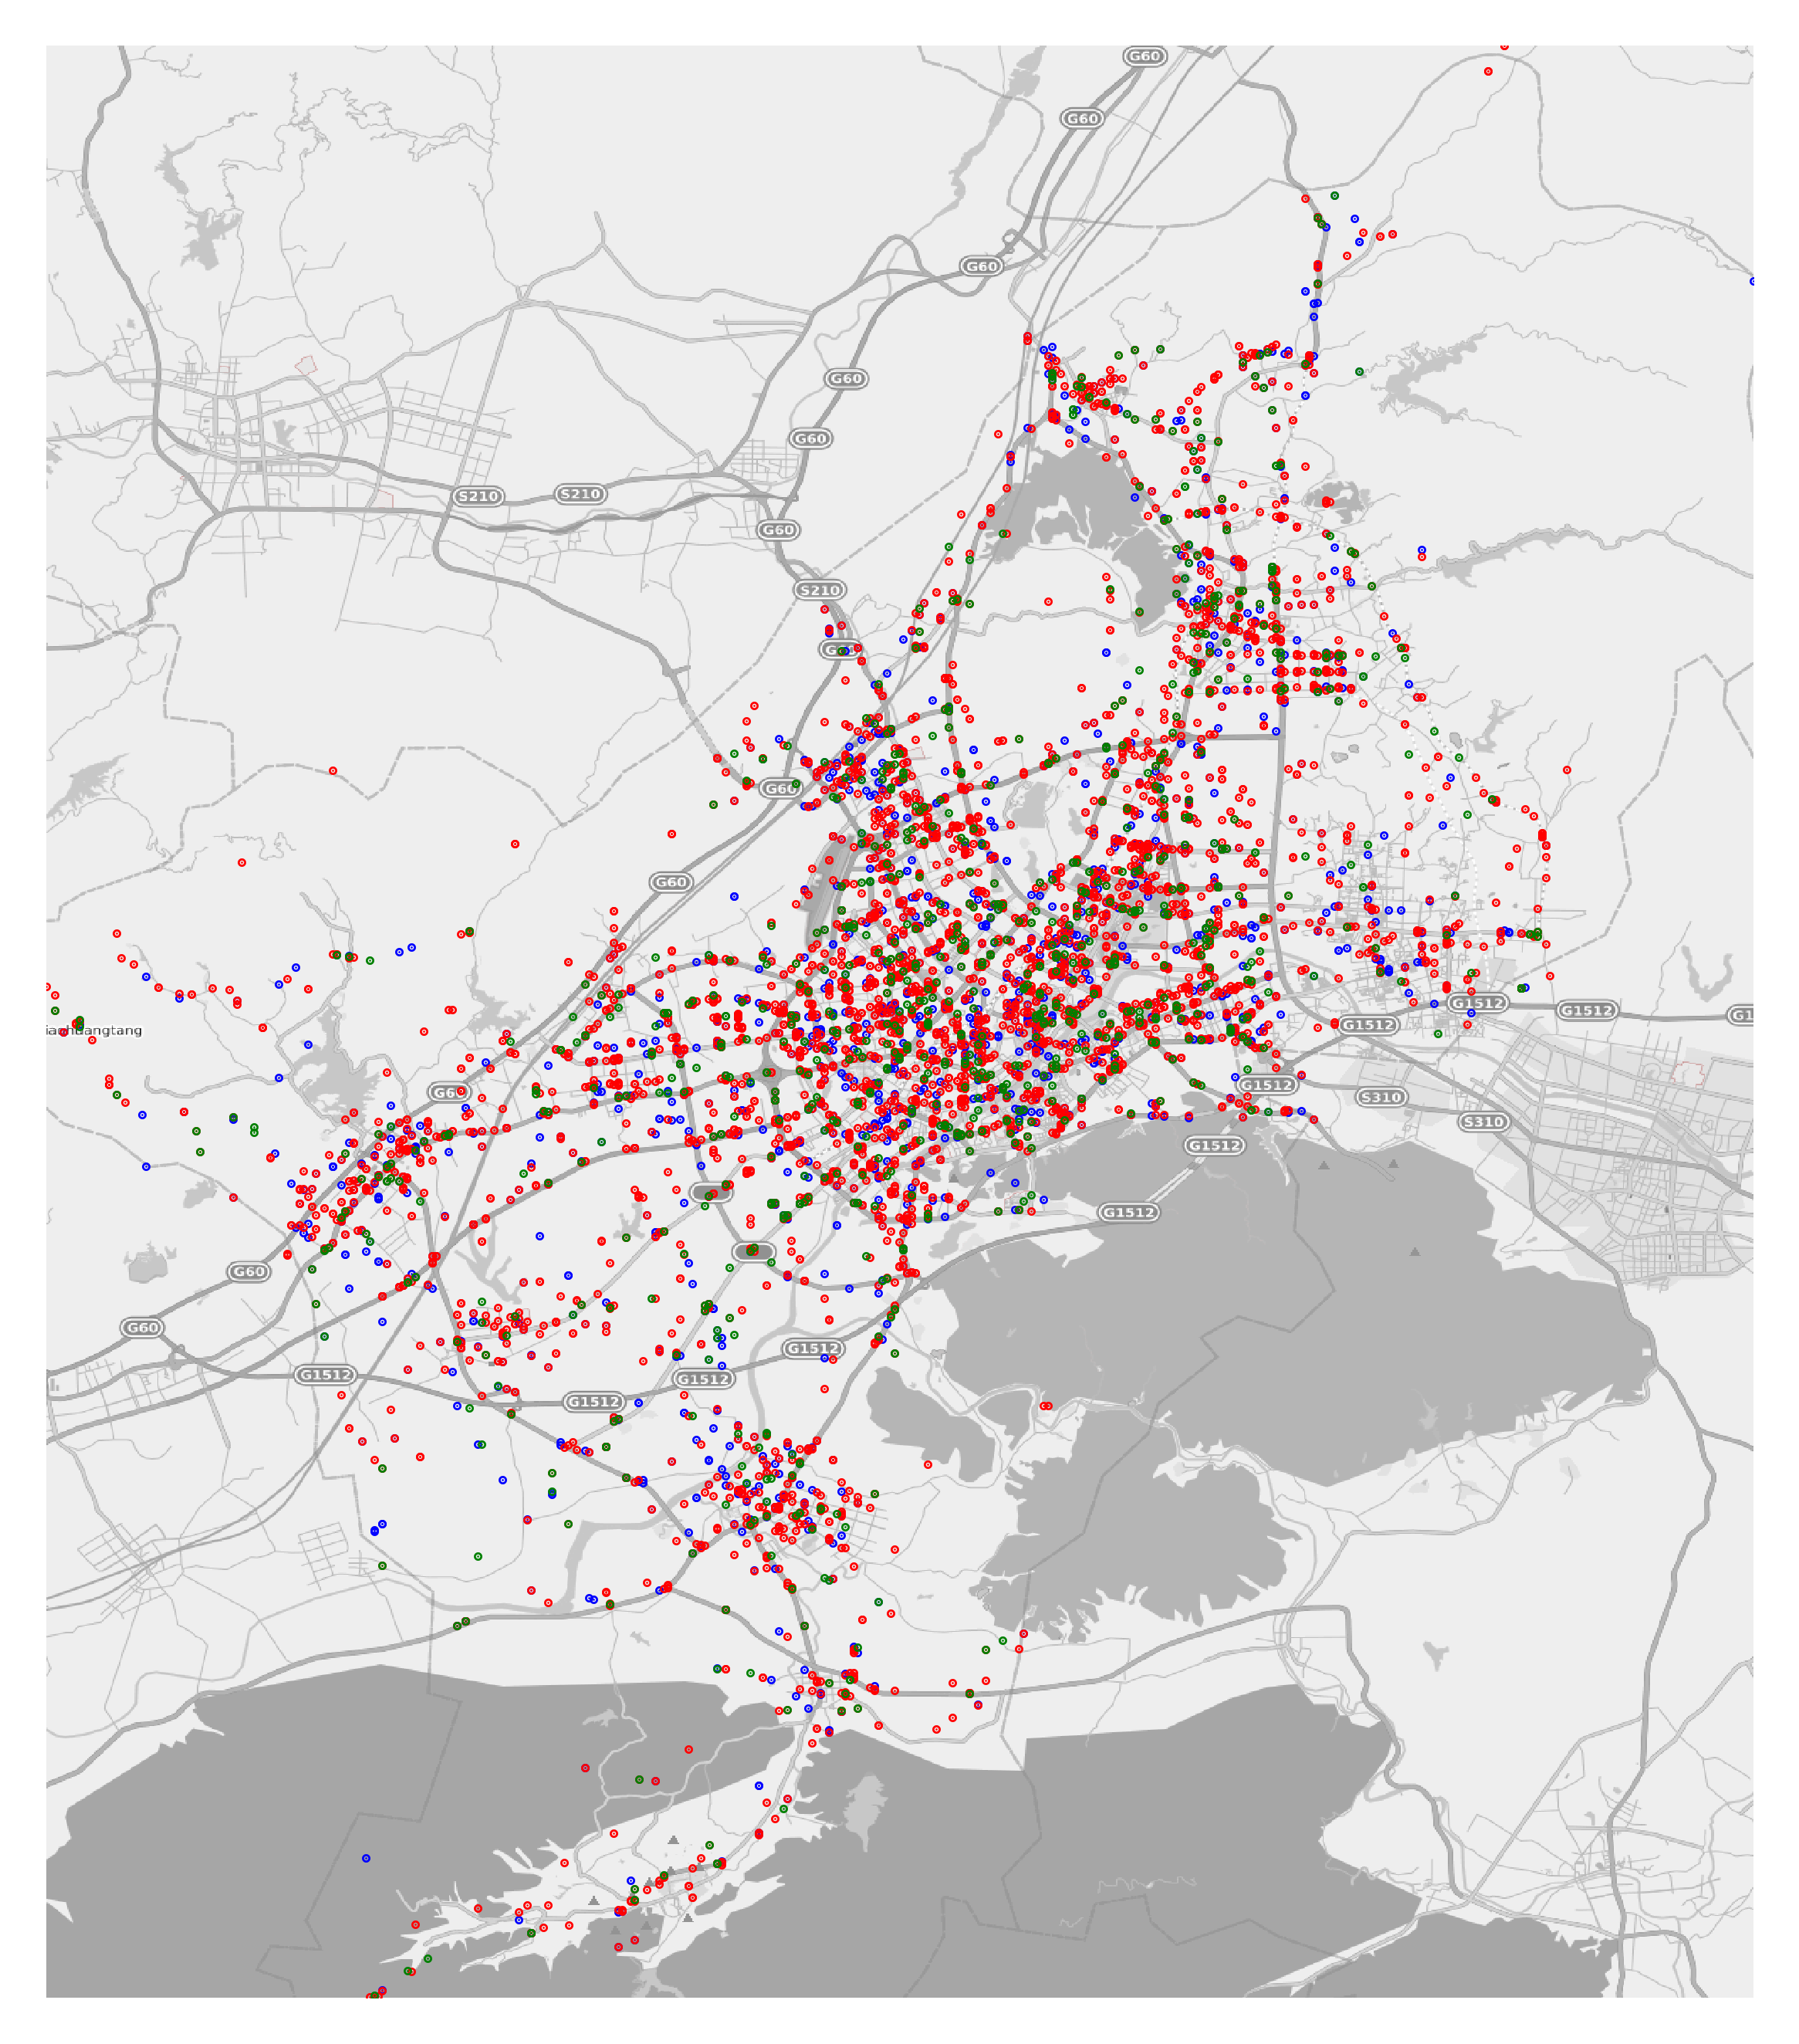

In [17]:
# 将三种类型的POI展示在地图上
bounds = [min(tmp['lng']),min(tmp['lat']),max(tmp['lng']),max(tmp['lat'])]
fig     = plt.figure(1,(6,6),dpi = 600)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))
#背景
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)
#colorbar
pallete_name = "autumn_r"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
norm = mpl.colors.Normalize(vmin=None, vmax=None)
#plot scatters
plt.scatter(tmp[tmp['label']==0]['lng'],tmp[tmp['label']==0]['lat'],c = "blue" ,s= 0.1)
plt.scatter(tmp[tmp['label']==1]['lng'],tmp[tmp['label']==1]['lat'],c = "red" ,s= 0.1)
plt.scatter(tmp[tmp['label']==2]['lng'],tmp[tmp['label']==2]['lat'],c = "green" ,s= 0.1)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## 4.2香农熵计算

In [249]:
# 利用dent1-dent4计算香农熵
def calshannon(ser):
    tmp = 0
    ser=ser[ser>0]
    for i in range(len(ser)):
        tmp = tmp + ser[i]*math.log(ser[i] , 4)
    return -tmp

cam['shan'] = cam[['dent1','dent2','dent3','dent4']].apply(calshannon , axis=1)
cam.head(2)

lng      lat  060000  130000  170000  120000  090000  050000  110000  \
0  120.082  29.2900     880      85     251      54     206     595       9   
1  120.084  29.2926     962      90     243      53     199     571       8   

   070000  ...      fdt1      fdt2      fdt3      fdt4     dent1     dent2  \
0     624  ...  0.000541  0.000279  0.000633  0.000475  0.280444  0.144611   
1     656  ...  0.000565  0.000270  0.000654  0.000474  0.288092  0.137532   

      dent3     dent4  label     shan  
0  0.328329  0.246616      1  0.97173  
1  0.333063  0.241313      1  0.96705  

[2 rows x 26 columns]

In [250]:
cam[['shan']].describe()

shan
count  8214.000000
mean      0.919032
std       0.127384
min      -0.000000
25%       0.918874
50%       0.967706
75%       0.983985
max       0.999997

## 4.3数据保存至本地

In [252]:
cam[['lng','lat','label','shan']].to_csv("各电警土地利用性质及香农熵.csv",encoding = 'gbk', index=False)